### processing pipeline before notebook work

python3 SpikeCounter/cluster/dcimg_folders_to_expt_data.py /n/holyscratch01/cohen_lab/bjia/20230329_agarose_encased_noABTX/

python3 SpikeCounter/cluster/run_preprocess_stim_jobs2.py /n/holyscratch01/cohen_lab/bjia/20230329_agarose_encased_noABTX None --remove_from_start 1 --remove_from_end 20 --n_pcs=40 --scale_factor=1 --denoise 0 --decorrelate 1 --start_from_downsampled 0 > jobs.txt

Manually define ROIs

python3 SpikeCounter/cluster/run_clicky_calcium_jobs.py /n/holyscratch01/cohen_lab/bjia/20230329_agarose_encased_noABTX/corrected /n/holyscratch01/cohen_lab/bjia/20230329_agarose_encased_noABTX/analysis/ROIs.tif

In [1]:
import sys
import os
import warnings
from pathlib import Path
sys.path.append(os.getenv("SPIKECOUNTER_PATH"))

from spikecounter.analysis import traces
from spikecounter.ui import visualize
from spikecounter import utils

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from datetime import datetime
from scipy import signal, stats, interpolate, optimize
from scipy.ndimage.filters import uniform_filter1d
import matplotlib.lines as mlines
import matplotlib.colors as colors
import seaborn as sns
import pickle
import os
from scipy.io import savemat
import scipy.io as scio
import colorcet as cc
import skimage.io as skio
import importlib

biopubs_style = Path(os.getenv("SPIKECOUNTER_PATH"), "config", "bio_publications.mplstyle")
plt.style.use(
    biopubs_style
)
warnings.filterwarnings("once")

In [3]:
input_datadir = Path(os.getenv("ANALYSIS_OUTPUT_ROOTDIR"), "2022 First Heartbeat_Submitted", 
                       "Figures/Data/Figure1/")
expts = ["20210420_gcamp_widefield", \
         "20210716_gcamp_widefield", "20210724_gcamp_widefield"]
datadirs = [input_datadir/d for d in expts]
expt_moments = [scio.loadmat(datadir/"all_moments.mat") for datadir in datadirs]

In [4]:
# Combine experiments for unperturbed data
n_traces_per_expt = [moments["all_freqs"].shape[0] for moments in expt_moments]
unaligned_frequencies, unaligned_covs, all_index_offsets = zip(*[(moments["all_freqs"], moments["covs"],
                                    moments["idx_offsets"].ravel()) for moments in expt_moments])
dt = expt_moments[0]["hpf"].ravel()[1]-expt_moments[0]["hpf"].ravel()[0]
aligned_frequencies, global_time_freq = utils.align_traces(unaligned_frequencies, all_index_offsets)
aligned_covs, _ = utils.align_traces(unaligned_covs, all_index_offsets)
time_rel_offset = global_time_freq*dt

In [5]:
def plot_freq_cv_with_cutoffs(axs, aligned_frequencies, aligned_covs, index_cutoffs):
    for i, aligned_cov in enumerate(aligned_covs):
        axs[i].set_title("%d" % i)
        axs[i].plot(aligned_frequencies[i,:])
        axs[i].plot(aligned_frequencies[i,:index_cutoffs[i]])
        ax2 = axs[i].twinx()
        ax2.plot(aligned_cov, color="C2")
        ax2.plot(aligned_cov[:index_cutoffs[i]], color="C4")

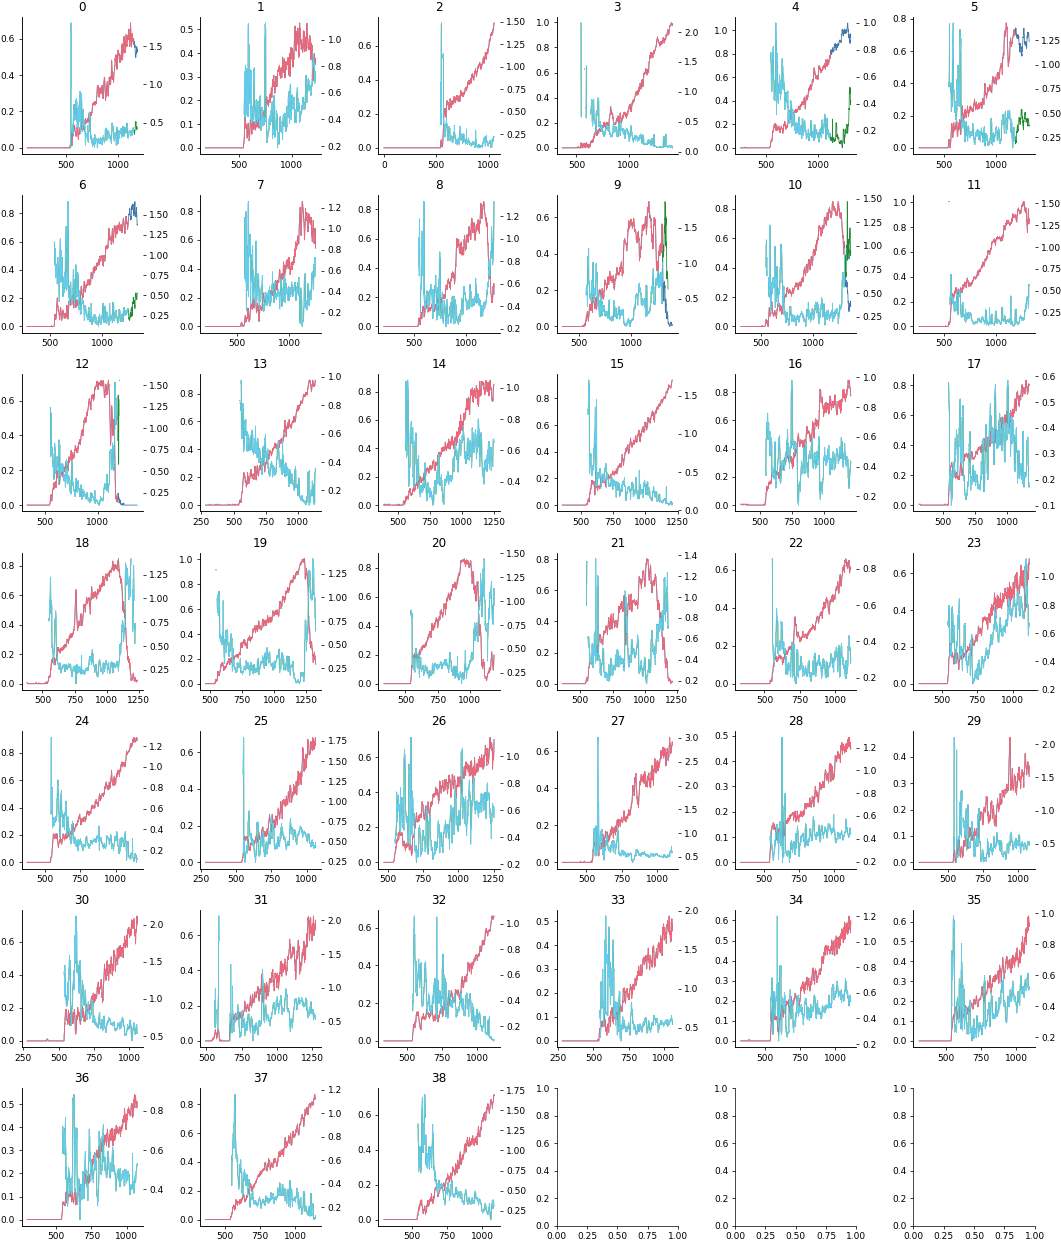

In [6]:
# Manually define times to throw out because of SNR dropoff
index_cutoffs = np.ones(aligned_covs.shape[0], dtype=int)*aligned_covs.shape[1]
index_cutoffs[[0,4,5,6,9,10,11,12]] = np.array([1150, 1120, 1180, 1250, 1300, 1300, 1350, 1190])
fig1, axs = visualize.tile_plots_conditions(np.arange(aligned_covs.shape[0]), (2.5,2.5))
plot_freq_cv_with_cutoffs(axs, aligned_frequencies, aligned_covs, index_cutoffs)
plt.tight_layout()

In [7]:
for i in range(aligned_frequencies.shape[0]):
    if index_cutoffs[i] < aligned_frequencies.shape[1]:
        aligned_frequencies[i,index_cutoffs[i]:] = np.nan
        aligned_covs[i,index_cutoffs[i]:] = np.nan

### tnnt2a

In [8]:
datadirs_tnnt2a = [input_datadir/d for d in ["20211022_widefield_tnnt2aMO_control", "20230510_widefield_tnnt2a"]]
expt_moments_tnnt2a = [scio.loadmat(datadir/"all_moments.mat") for datadir in datadirs_tnnt2a]
n_traces_per_expt_tnnt2a = [moments["all_freqs"].shape[0] for moments in expt_moments_tnnt2a]
unaligned_frequencies_tnnt2a, unaligned_covs_tnnt2a, all_index_offsets_tnnt2a = zip(*[(moments["all_freqs"], moments["covs"],
                                    moments["idx_offsets"].ravel()) for moments in expt_moments_tnnt2a])
dt_tnnt2a = expt_moments_tnnt2a[0]["hpf"].ravel()[1]-expt_moments_tnnt2a[0]["hpf"].ravel()[0]
aligned_frequencies_tnnt2a, global_time_freq_tnnt2a = utils.align_traces(unaligned_frequencies_tnnt2a, all_index_offsets_tnnt2a)
aligned_covs_tnnt2a, _ = utils.align_traces(unaligned_covs_tnnt2a, all_index_offsets_tnnt2a)
time_rel_offset_tnnt2a = global_time_freq_tnnt2a*dt_tnnt2a


In [9]:
n_traces_per_expt_tnnt2a

[12, 10]

In [8]:
index_cutoffs_tnnt2a = np.ones(aligned_covs_tnnt2a.shape[0], dtype=int)*aligned_covs_tnnt2a.shape[1]
index_cutoffs_tnnt2a[[13,18,20,21]] = np.array([750,760,680,730])
fig1, axs = visualize.tile_plots_conditions(np.arange(aligned_covs_tnnt2a.shape[0]), (2.5,2.5))
plot_freq_cv_with_cutoffs(axs, aligned_frequencies_tnnt2a, aligned_covs_tnnt2a, index_cutoffs_tnnt2a)
plt.tight_layout()

NameError: name 'aligned_covs_tnnt2a' is not defined

In [ ]:
for i in range(aligned_frequencies_tnnt2a.shape[0]):
    if index_cutoffs_tnnt2a[i] < aligned_frequencies_tnnt2a.shape[1]:
        aligned_frequencies_tnnt2a[i,index_cutoffs_tnnt2a[i]:] = np.nan
        aligned_covs_tnnt2a[i,index_cutoffs_tnnt2a[i]:] = np.nan

In [ ]:
edges_tnnt2a = np.append([0], np.cumsum(n_traces_per_expt_tnnt2a))
fig1, ax1 = plt.subplots(figsize=(2.5,2))
for i in range(2):
    aligned_frequencies = aligned_frequencies_tnnt2a[edges_tnnt2a[i]:edges_tnnt2a[i+1]]
    mean_freq = np.nanmean(aligned_frequencies, axis=0)
    std_freq = np.nanstd(aligned_frequencies, axis=0)
    ax1.plot(time_rel_offset_tnnt2a, mean_freq, color="C%d" % i, label=r"($-$)MO/($+$)aBTX Batch %d" % (i+1))
    ax1.fill_between(time_rel_offset_tnnt2a, mean_freq-std_freq, mean_freq+std_freq, alpha=0.1, color="C%d" %i)

    ax1.set_xlabel("Time after onset (h)")

In [ ]:
fig1, ax1 = plt.subplots(figsize=(2.5,2))
for i in range(2):
    aligned_covs = aligned_covs_tnnt2a[edges_tnnt2a[i]:edges_tnnt2a[i+1]]
    mean_cov = np.nanmean(aligned_covs, axis=0)
    std_cov = np.nanstd(aligned_covs, axis=0)
    ax1.plot(time_rel_offset_tnnt2a, mean_cov, color="C%d" % i)
    ax1.fill_between(time_rel_offset_tnnt2a, mean_cov-std_cov, mean_cov+std_cov, alpha=0.1, color="C%d" %i)


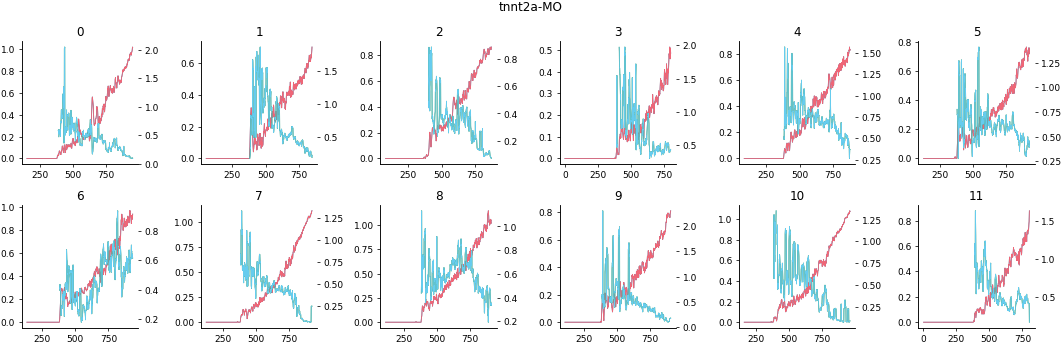

In [9]:
tnnt_expt = "20211022_widefield_tnnt2aMO_control"
tnnt_moments = scio.loadmat(str(input_datadir/tnnt_expt/"all_moments.mat"))
tnnt_covs = tnnt_moments["covs_aligned"]
tnnt_freqs = tnnt_moments["all_freqs_aligned"]
tnnt_ts = tnnt_moments["aligned_time_hpf"].ravel()
index_cutoffs = np.ones(tnnt_covs.shape[0], dtype=int)*tnnt_covs.shape[1]
fig1, axs = visualize.tile_plots_conditions(np.arange(tnnt_covs.shape[0]), (2.5,2.5), n_rows=2)
plot_freq_cv_with_cutoffs(axs, tnnt_freqs, tnnt_covs, index_cutoffs)
fig1.suptitle("tnnt2a-MO")
plt.tight_layout()

In [14]:
tnnt_expt2 = "20230510_widefield_tnnt2a"
tnnt_moments2 = scio.loadmat(str(input_datadir/tnnt_expt2/"all_moments.mat"))
tnnt_covs2 = tnnt_moments2["covs_aligned"]
tnnt_freqs2 = tnnt_moments2["all_freqs_aligned"]
tnnt_ts2 = tnnt_moments2["aligned_time_hpf"].ravel()
index_cutoffs = np.ones(tnnt_covs2.shape[0], dtype=int)*tnnt_covs2.shape[1]
fig1, axs = visualize.tile_plots_conditions(np.arange(tnnt_covs2.shape[0]), (2.5,2.5), n_rows=2)
plot_freq_cv_with_cutoffs(axs, tnnt_freqs2, tnnt_covs2, index_cutoffs)
fig1.suptitle("tnnt2a-MO")
plt.tight_layout()

KeyError: 'aligned_time_hpf'

### Agarose

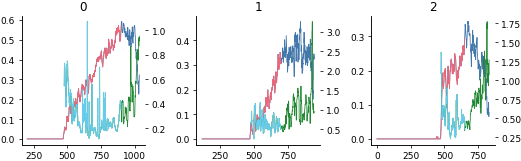

In [10]:
agarose_expt = "20230329_agarose_encased_noABTX_widefield"
agarose_moments = scio.loadmat(input_datadir/agarose_expt/"all_moments.mat")
agarose_covs = agarose_moments["covs_aligned"]
agarose_freqs = agarose_moments["all_freqs_aligned"]
agarose_ts = agarose_moments["aligned_time_hpf"].ravel()
index_cutoffs = np.ones(agarose_covs.shape[0], dtype=int)*agarose_covs.shape[1]
index_cutoffs[[0,1,2]] = [900,700,650]
fig1, axs = visualize.tile_plots_conditions(np.arange(agarose_covs.shape[0]), (2.5,2.5), n_rows=1)
plot_freq_cv_with_cutoffs(axs, agarose_freqs, agarose_covs, index_cutoffs)
plt.tight_layout()

In [11]:
for i in range(agarose_freqs.shape[0]):
    if index_cutoffs[i] < agarose_freqs.shape[1]:
        agarose_freqs[i,index_cutoffs[i]:] = np.nan
        agarose_covs[i,index_cutoffs[i]:] = np.nan

### FRGECO

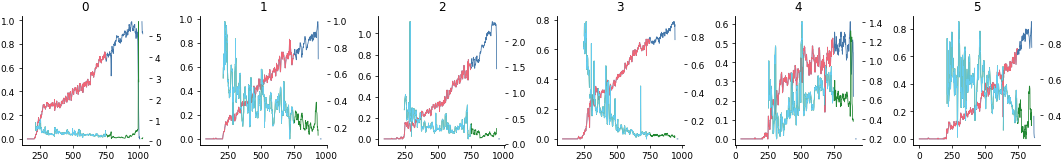

In [12]:
frgeco_expt = "20220222_frgeco_nkx_widefield"
frgeco_moments = scio.loadmat(input_datadir/frgeco_expt/"all_moments.mat")
frgeco_covs = frgeco_moments["covs_aligned"]
frgeco_freqs = frgeco_moments["all_freqs_aligned"]
frgeco_ts = frgeco_moments["aligned_time_hpf"].ravel()
index_cutoffs = np.ones(frgeco_covs.shape[0], dtype=int)*750
# index_cutoffs[[0,1,2]] = [900,700,650]
fig1, axs = visualize.tile_plots_conditions(np.arange(frgeco_covs.shape[0]), (2.5,2.5), n_rows=1)
plot_freq_cv_with_cutoffs(axs, frgeco_freqs, frgeco_covs, index_cutoffs)
plt.tight_layout()

### Compare

In [11]:
output_datadir = input_datadir/"abtx_tnnt2a_agarose_comparison"
os.makedirs(output_datadir, exist_ok=True)

/tmp/ipykernel_172119/24866689.py:7: RuntimeWarning: Mean of empty slice
  mean_freq = np.nanmean(aligned_frequencies, axis=0)
/n/home11/bjia/.conda/envs/bjia2/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1670: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/tmp/ipykernel_172119/24866689.py:7: RuntimeWarning: Mean of empty slice
  mean_freq = np.nanmean(aligned_frequencies, axis=0)
/n/home11/bjia/.conda/envs/bjia2/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1670: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/tmp/ipykernel_172119/24866689.py:7: RuntimeWarning: Mean of empty slice
  mean_freq = np.nanmean(aligned_frequencies, axis=0)
/n/home11/bjia/.conda/envs/bjia2/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1670: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/

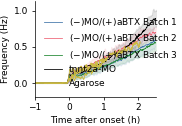

In [47]:
fig1, ax1 = plt.subplots(figsize=(2.5,2))
for i in range(3):
    moments = expt_moments[i]
    aligned_frequencies = moments["all_freqs_aligned"]
    all_offsets = moments["idx_offsets"]
    hpf = moments["hpf"].ravel()
    mean_freq = np.nanmean(aligned_frequencies, axis=0)
    std_freq = np.nanstd(aligned_frequencies, axis=0)
    x = (np.arange(len(mean_freq)) - np.max(all_offsets))*(hpf[1]-hpf[0])
    ax1.plot(x, mean_freq, color="C%d" % i, label=r"($-$)MO/($+$)aBTX Batch %d" % (i+1))
    ax1.fill_between(x, mean_freq-std_freq, mean_freq+std_freq, alpha=0.1, color="C%d" %i)

    ax1.set_xlabel("Time after onset (h)")

mean_tnnt2_freq = np.nanmean(tnnt_freqs, axis=0)
std_tnnt2_freq = np.nanstd(tnnt_freqs, axis=0)

ax1.plot(tnnt_ts, mean_tnnt2_freq, label="tnnt2a-MO", color="k")
ax1.fill_between(tnnt_ts, mean_tnnt2_freq-std_tnnt2_freq, mean_tnnt2_freq+std_tnnt2_freq, alpha=0.1, color="k")

ax1.plot(agarose_ts, agarose_freqs.T, color="C3")
ax1.plot(agarose_ts, agarose_freqs[0], color="C3", label="Agarose")

ax1.set_ylabel("Frequency (Hz)")
ax1.set_xlim(-1, 2.5)
ax1.legend()
plt.tight_layout()
plt.savefig(os.path.join(output_datadir, "frequency_comparison.svg"), dpi=300, bbox_inches="tight")
plt.savefig(os.path.join(output_datadir, "frequency_comparison.png"), dpi=300)

/tmp/ipykernel_172119/484053986.py:7: RuntimeWarning: Mean of empty slice
  mean_cov = np.nanmean(aligned_covs, axis=0)
/n/home11/bjia/.conda/envs/bjia2/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1670: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/tmp/ipykernel_172119/484053986.py:7: RuntimeWarning: Mean of empty slice
  mean_cov = np.nanmean(aligned_covs, axis=0)
/n/home11/bjia/.conda/envs/bjia2/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1670: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/tmp/ipykernel_172119/484053986.py:7: RuntimeWarning: Mean of empty slice
  mean_cov = np.nanmean(aligned_covs, axis=0)
/n/home11/bjia/.conda/envs/bjia2/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1670: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/tmp/ipykernel_172119/

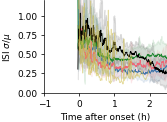

In [45]:
fig1, ax1 = plt.subplots(figsize=(2.5,2))
for i in range(3):
    moments = expt_moments[i]   
    aligned_covs = moments["covs_aligned"]
    all_offsets = moments["idx_offsets"]
    hpf = moments["hpf"].ravel()
    mean_cov = np.nanmean(aligned_covs, axis=0)
    std_cov = np.nanstd(aligned_covs, axis=0)
    x = (np.arange(len(mean_cov)) - np.max(all_offsets))*(hpf[1]-hpf[0])
    ax1.plot(x, mean_cov, color="C%d" % i)
    ax1.fill_between(x, mean_cov-std_cov, mean_cov+std_cov, alpha=0.1, color="C%d" %i)

    ax1.set_xlabel("Time after onset (h)")
    
mean_tnnt2_freq = np.nanmean(tnnt_covs, axis=0)
std_tnnt2_freq = np.nanstd(tnnt_covs, axis=0)

ax1.plot(tnnt_ts, mean_tnnt2_freq, label="tnnt2a-MO", color="k")
ax1.fill_between(tnnt_ts, mean_tnnt2_freq-std_tnnt2_freq, mean_tnnt2_freq+std_tnnt2_freq, alpha=0.1, color="k")

ax1.plot(agarose_ts, agarose_covs.T, color="C3", alpha=0.5)
ax1.set_ylim(0,1.2)
ax1.set_xlim(-1, 2.5)
ax1.set_ylabel(r"ISI $\sigma/\mu$")
plt.tight_layout()
plt.savefig(os.path.join(output_datadir, "cv_comparison.svg"), dpi=300, bbox_inches="tight")
plt.savefig(os.path.join(output_datadir, "cv_comparison.png"), dpi=300)

In [84]:
all_hpf_starts = []
for moments in expt_moments:
    all_offsets = moments["idx_offsets"]
    hpf = moments["hpf"].ravel()
    print(all_offsets)
    print(len(hpf))
    moments["hpf_start"] = hpf[all_offsets].tolist()[0]
    all_hpf_starts.extend(moments["hpf_start"])
bins = np.linspace(np.min(all_hpf_starts), np.max(all_hpf_starts), 20)

[[418 373 550 186 290 288 268 348 334 209 243 289 224]]
1052
[[268 156 197 200 236 169  84 218 191]]
857
[[219 213 177 268  79 222 215 253 273  57 212 271 221 238 256 186 247]]
782


In [29]:
tnnt_hpf_starts = tnnt_moments["hpf"].ravel()[tnnt_moments["idx_offsets"]].tolist()[0]
agarose_hpf_starts = agarose_moments["hpf"].ravel()[agarose_moments["idx_offsets"]].tolist()[0]

In [88]:
hpf_starts = []
for moments in expt_moments:
    all_offsets = moments["idx_offsets"]
    hpf = moments["hpf"].ravel()
    hpf_starts.extend(hpf[all_offsets].tolist()[0])

In [26]:
output_datadir

PosixPath('/n/cohen_lab/Lab/Papers/2022 First Heartbeat_Submitted/Figures/Data/Figure1/abtx_tnnt2a_agarose_comparison')

In [50]:
expts

['20210420_gcamp_widefield',
 '20210716_gcamp_widefield',
 '20210724_gcamp_widefield']

In [49]:
expt_moments

[{'__header__': b'MATLAB 5.0 MAT-file Platform: posix, Created on: Sun Nov  6 10:49:18 2022',
  '__version__': '1.0',
  '__globals__': [],
  'idx_offsets': array([[418, 373, 550, 186, 290, 288, 268, 348, 334, 209, 243, 289, 224]]),
  'all_freqs': array([[0.        , 0.        , 0.        , ..., 0.54292186, 0.52559456,
          0.54292186],
         [0.        , 0.        , 0.        , ..., 0.36387316, 0.35232163,
          0.35232163],
         [0.        , 0.        , 0.        , ..., 0.72774632, 0.73352208,
          0.73352208],
         ...,
         [0.        , 0.        , 0.        , ..., 0.1617214 , 0.15594564,
          0.14439411],
         [0.        , 0.        , 0.        , ..., 0.86636467, 0.84903737,
          0.82593431],
         [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
          0.        ]]),
  'all_freqs_aligned': array([[nan, nan, nan, ..., nan, nan, nan],
         [nan, nan, nan, ..., nan, nan, nan],
         [ 0.,  0.,  0., ..., nan, nan

13
9
17


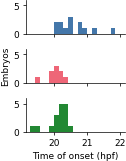

In [51]:
hpf_starts = []
fig1, axs = plt.subplots(3, 1, figsize=(2, 2.5), sharex=True)
axs = axs.ravel()
for idx, moments in enumerate(expt_moments):
    all_offsets = moments["idx_offsets"]
    print(len(all_offsets.ravel()))
    hpf = moments["hpf"].ravel()
    axs[idx].hist(hpf[all_offsets].tolist()[0], color=f"C{idx}", bins = np.linspace(19.3, 22, 20))
    axs[idx].set_ylim(0, 6)
    hpf_starts.extend(hpf[all_offsets].tolist()[0])
axs[1].set_ylabel("Embryos")
axs[2].set_xlabel("Time of onset (hpf)")
plt.tight_layout()
plt.savefig(output_datadir.parent/"batchwise_start_time.svg", dpi=300, bbox_inches="tight")

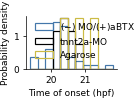

In [48]:
bins = np.linspace(np.min(hpf_starts), np.max(hpf_starts), 12)
mean_hpf = np.mean(hpf_starts)
fig1, ax1 = plt.subplots(figsize=(2,1.4))
ax1.hist(hpf_starts, linewidth=1.2, bins=bins, facecolor=(0,0,0,0), edgecolor="C0", density=True, label="($-$) MO/($+$)aBTX")
ax1.hist(tnnt_hpf_starts, linewidth=1.2, bins=bins, facecolor=(0,0,0,0), edgecolor="k", density=True, label="tnnt2a-MO")
ax1.hist(agarose_hpf_starts, linewidth=1.2, bins=bins, edgecolor="C3", facecolor=(0,0,0,0), density=True, label="Agarose")

# ymin, ymax = ax1.get_ylim()
# ax1.vlines(mean_hpf, ymin=ymin, ymax=ymax, linewidth=1.5, color="#A91F23")
# ax1.text(mean_hpf+0.05, ymax*0.95, r"$\mu = %.1f\ \mathrm{hpf}$" % mean_hpf, color="#A91F23")
# ax1.text(21.5, 10, r"$n = %d$" % len(hpf_starts))
ax1.legend()
ax1.set_xlabel("Time of onset (hpf)")
ax1.set_ylabel("Probability density")
plt.tight_layout()
plt.savefig(os.path.join(output_datadir, "initiation_time_comparison.svg"))

/tmp/ipykernel_46129/492713027.py:7: RuntimeWarning: Mean of empty slice
  mean_freq = np.nanmean(aligned_frequencies, axis=0)
/n/home11/bjia/.conda/envs/bjia2/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1670: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/tmp/ipykernel_46129/492713027.py:7: RuntimeWarning: Mean of empty slice
  mean_freq = np.nanmean(aligned_frequencies, axis=0)
/n/home11/bjia/.conda/envs/bjia2/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1670: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/tmp/ipykernel_46129/492713027.py:7: RuntimeWarning: Mean of empty slice
  mean_freq = np.nanmean(aligned_frequencies, axis=0)
/n/home11/bjia/.conda/envs/bjia2/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1670: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/

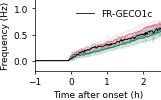

In [19]:
fig1, ax1 = plt.subplots(figsize=(2.5,1.65))
for i in range(3):
    moments = expt_moments[i]
    aligned_frequencies = moments["all_freqs_aligned"]
    all_offsets = moments["idx_offsets"]
    hpf = moments["hpf"].ravel()
    mean_freq = np.nanmean(aligned_frequencies, axis=0)
    std_freq = np.nanstd(aligned_frequencies, axis=0)
    x = (np.arange(len(mean_freq)) - np.max(all_offsets))*(hpf[1]-hpf[0])
    ax1.plot(x, mean_freq, color="C%d" % i)
    ax1.fill_between(x, mean_freq-std_freq, mean_freq+std_freq, alpha=0.1, color="C%d" %i)

    ax1.set_xlabel("Time after onset (h)")

mean_frgeco_freq = np.nanmean(frgeco_freqs, axis=0)
std_frgeco_freq = np.nanstd(frgeco_freqs, axis=0)

ax1.plot(frgeco_ts, mean_frgeco_freq, label="FR-GECO1c", color="k")
ax1.fill_between(frgeco_ts, mean_frgeco_freq-std_frgeco_freq, mean_frgeco_freq+std_frgeco_freq, alpha=0.1, color="k")

ax1.set_ylabel("Frequency (Hz)")
ax1.set_xlim(-1, 2.5)
ax1.legend()
plt.tight_layout()
plt.savefig(os.path.join(output_datadir, "frequency_comparison_frgeco.svg"), dpi=300, bbox_inches="tight")
# plt.savefig(os.path.join(output_datadir, "frequency_comparison.png"), dpi=300)

/tmp/ipykernel_46129/1225986122.py:7: RuntimeWarning: Mean of empty slice
  mean_cov = np.nanmean(aligned_covs, axis=0)
/n/home11/bjia/.conda/envs/bjia2/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1670: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/tmp/ipykernel_46129/1225986122.py:7: RuntimeWarning: Mean of empty slice
  mean_cov = np.nanmean(aligned_covs, axis=0)
/n/home11/bjia/.conda/envs/bjia2/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1670: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/tmp/ipykernel_46129/1225986122.py:7: RuntimeWarning: Mean of empty slice
  mean_cov = np.nanmean(aligned_covs, axis=0)
/n/home11/bjia/.conda/envs/bjia2/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1670: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/tmp/ipykernel_46129/1

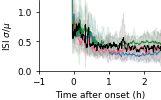

In [20]:
fig1, ax1 = plt.subplots(figsize=(2.5,1.65))
for i in range(3):
    moments = expt_moments[i]   
    aligned_covs = moments["covs_aligned"]
    all_offsets = moments["idx_offsets"]
    hpf = moments["hpf"].ravel()
    mean_cov = np.nanmean(aligned_covs, axis=0)
    std_cov = np.nanstd(aligned_covs, axis=0)
    x = (np.arange(len(mean_cov)) - np.max(all_offsets))*(hpf[1]-hpf[0])
    ax1.plot(x, mean_cov, color="C%d" % i)
    ax1.fill_between(x, mean_cov-std_cov, mean_cov+std_cov, alpha=0.1, color="C%d" %i)

    ax1.set_xlabel("Time after onset (h)")
    
mean_frgeco_freq = np.nanmean(frgeco_covs, axis=0)
std_frgeco_freq = np.nanstd(frgeco_covs, axis=0)

ax1.plot(frgeco_ts, mean_frgeco_freq, label="FR-GECO1c", color="k")
ax1.fill_between(frgeco_ts, mean_frgeco_freq-std_frgeco_freq, mean_frgeco_freq+std_frgeco_freq, alpha=0.1, color="k")
ax1.set_ylim(0,1.2)
ax1.set_xlim(-1, 2.5)
ax1.set_ylabel(r"ISI $\sigma/\mu$")
plt.tight_layout()
plt.savefig(os.path.join(output_datadir, "cv_comparison_frgeco.svg"), dpi=300, bbox_inches="tight")
# plt.savefig(os.path.join(output_datadir, "cv_comparison.png"), dpi=300)

13
9
17


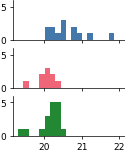

In [21]:
hpf_starts = []
fig1, axs = plt.subplots(3, 1, figsize=(2, 2.5), sharex=True)
axs = axs.ravel()
for idx, moments in enumerate(expt_moments):
    all_offsets = moments["idx_offsets"]
    print(len(all_offsets.ravel()))
    hpf = moments["hpf"].ravel()
    axs[idx].hist(hpf[all_offsets].tolist()[0], color=f"C{idx}", bins = np.linspace(19.3, 22, 20))
    axs[idx].set_ylim(0, 6)
    hpf_starts.extend(hpf[all_offsets].tolist()[0])

In [22]:
frgeco_hpf_starts = frgeco_moments["hpf"].ravel()[frgeco_moments["idx_offsets"]].tolist()[0]


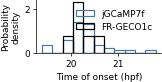

In [25]:
bins = np.linspace(np.min(hpf_starts), np.max(hpf_starts), 12)
mean_hpf = np.mean(hpf_starts)
fig1, ax1 = plt.subplots(figsize=(2.5,1.4))
ax1.hist(hpf_starts, linewidth=1.2, bins=bins, facecolor=(0,0,0,0), edgecolor="C0", density=True, label="jGCaMP7f")
ax1.hist(frgeco_hpf_starts, linewidth=1.2, bins=bins, facecolor=(0,0,0,0), edgecolor="k", density=True, label="FR-GECO1c")
ax1.legend()
ax1.set_xlabel("Time of onset (hpf)")
ax1.set_ylabel("Probability\ndensity")
plt.tight_layout()
plt.savefig(os.path.join(output_datadir, "initiation_time_comparison_frgeco.svg"))